<a href="https://colab.research.google.com/github/BootCamp-BMA/colabs/blob/main/diziribert_marabert_camelbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === INSTALL DEPENDENCIES ===
# !pip install -U transformers datasets peft


# === IMPORTS ===
import os
import json
import time
import random
from datetime import timedelta
from pathlib import Path

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import (
    AutoConfig,
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset, DatasetDict,load_dataset
from peft import get_peft_model, LoraConfig, TaskType

In [ ]:
# === MOUNT DRIVE ===
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === SETUP DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# === GLOBAL CONFIG ===
DATA_PATH = 'drive/MyDrive/WithLora/cleaned_data.csv'

MODEL_NAMES = [
    "alger-ia/dziribert",
    "CAMeL-Lab/bert-base-arabic-camelbert-da",
    "UBC-NLP/MARBERT"
]
NON_LORA_LOG = "drive/MyDrive/WithLora/nonLoRAExprements.json"
LORA_LOG     = "drive/MyDrive/WithLora/LoRAExperiments.json"

MAX_TIME       = 16 * 60 * 60  # 12h
MAX_NON_LORA   = 51
MAX_LORA       = 50

LEARNING_RATES = [1e-5, 2e-5, 3e-5, 5e-5, 1e-4, 2e-4]
BATCH_SIZES    = [8, 16, 32]
NUM_EPOCHS     = [3, 4, 5, 6]
WEIGHT_DECAYS  = [0.01, 0.02, 0.05]

LORA_R         = [4, 8, 16]
LORA_ALPHA     = [8, 16, 32]
LORA_DROPOUT   = [0.1, 0.2, 0.3]

In [ ]:
# === HELPERS ===
def load_json(path):
    return json.load(open(path)) if os.path.exists(path) else []

def save_json(path, data):
    Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)

def tokenize_dataset(raw_ds, tokenizer):
    def fn(ex):
        return tokenizer(ex['news'], padding='max_length', truncation=True, max_length=512)
    tok = raw_ds.map(fn, batched=True)
    tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    return tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

def init_trainable_layers_randomly(num_layers):
    """Return a dict {layer_idx: bool} at random."""
    return {i: bool(random.getrandbits(1)) for i in range(num_layers)}

def is_duplicate(cfg, all_exps):
    return any(all(cfg[k] == exp.get(k) for k in cfg) for exp in all_exps)


In [ ]:
# === LOAD & SPLIT DATA ===
df = pd.read_csv(DATA_PATH)
train_df, temp = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

raw_ds = DatasetDict({
    'train':     Dataset.from_pandas(train_df),
    'validation':Dataset.from_pandas(val_df),
    'test':      Dataset.from_pandas(test_df),
})

print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")

Train/Val/Test sizes: 7708/964/964


In [ ]:
# === NON-LoRA EXPERIMENTS ===
non_lora_exps = load_json(NON_LORA_LOG)
print(f"→ Loaded {len(non_lora_exps)} past non-LoRA experiments")

start_time = time.time()
exp_count   = len(non_lora_exps)

while time.time() - start_time < MAX_TIME and exp_count < MAX_NON_LORA:
    # 1) sample hyperparams + model

    length = len(MODEL_NAMES)
    model_name = MODEL_NAMES[exp_count % length]

    cfg = {
      'model_name':    model_name,
      'learning_rate': random.choice(LEARNING_RATES),
      'batch_size':    random.choice(BATCH_SIZES),
      'num_epochs':    random.choice(NUM_EPOCHS),
      'weight_decay':  random.choice(WEIGHT_DECAYS),
    }

    # 2) get num_layers & random mask
    conf = AutoConfig.from_pretrained(model_name)
    num_layers = conf.num_hidden_layers
    mask = init_trainable_layers_randomly(num_layers)
    cfg['trainable_layers'] = mask

    # 3) duplicate check
    if is_duplicate(cfg, non_lora_exps):
        print("↳ Duplicate config + mask → skipping")
        continue

    exp_count += 1
    exp_start = time.time()

    # 4) print pre-train card
    print(f"""
===========================================
Experiment number {exp_count}
-------------------------------------------
Config & init before training:
{json.dumps(cfg, indent=2)}
-------------------------------------------
""")

    # 5) prep tokenizer & data
    tokenizer = BertTokenizer.from_pretrained(model_name)
    tok_ds    = tokenize_dataset(raw_ds, tokenizer)

    # 6) load & freeze layers
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    for idx, trainable in mask.items():
        layer = model.bert.encoder.layer[idx]
        for p in layer.parameters():
            p.requires_grad = trainable

    # 7) trainer
    args = TrainingArguments(
      output_dir=f"./results-full/exp_{exp_count}",
      learning_rate=cfg['learning_rate'],
      per_device_train_batch_size=cfg['batch_size'],
      per_device_eval_batch_size=cfg['batch_size'],
      num_train_epochs=cfg['num_epochs'],
      weight_decay=cfg['weight_decay'],
      logging_dir=f"./logs-full/exp_{exp_count}",
      report_to="none"
    )
    trainer = Trainer(
      model=model,
      args=args,
      train_dataset=tok_ds['train'],
      eval_dataset= tok_ds['validation'],
      compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate(tok_ds['test'])

    # 8) print post-train card
    print(f"""
Results after training:
{json.dumps(metrics, indent=2)}
Elapsed: {str(timedelta(seconds=int(time.time()-exp_start)))}
===========================================
""")

    # 9) log experiment
    record = {
      **cfg,
      'accuracy': metrics.get('eval_accuracy'),
      'elapsed_time_sec': time.time() - exp_start,
      'elapsed_time_readable': str(timedelta(seconds=int(time.time()-exp_start)))
    }
    non_lora_exps.append(record)
    save_json(NON_LORA_LOG, non_lora_exps)

print("=== Non‑LoRA experiments done ===")

→ Loaded 51 past non-LoRA experiments
=== Non‑LoRA experiments done ===


In [ ]:
# === LoRA EXPERIMENTS ===
lora_exps = load_json(LORA_LOG)
print(f"→ Loaded {len(lora_exps)} past LoRA experiments")

start_time = time.time()
exp_count   = len(lora_exps)

while time.time() - start_time < MAX_TIME and exp_count < MAX_LORA:
    # sample






    length = len(MODEL_NAMES)
    model_name = MODEL_NAMES[exp_count % length]



    cfg = {
      'model_name':    model_name,
      'learning_rate': random.choice(LEARNING_RATES),
      'batch_size':    random.choice(BATCH_SIZES),
      'num_epochs':    random.choice(NUM_EPOCHS),
      'weight_decay':  random.choice(WEIGHT_DECAYS),
      'lora_r':        random.choice(LORA_R),
      'lora_alpha':    random.choice(LORA_ALPHA),
      'lora_dropout':  random.choice(LORA_DROPOUT),
    }

    conf = AutoConfig.from_pretrained(model_name)
    num_layers = conf.num_hidden_layers
    mask = init_trainable_layers_randomly(num_layers)
    cfg['trainable_layers'] = mask

    if is_duplicate(cfg, lora_exps):
        print("↳ Duplicate config + mask → skipping")
        continue

    exp_count += 1
    exp_start = time.time()

    # pre-train card
    print(f"""
===========================================
LoRA Experiment #{exp_count}
-------------------------------------------
Config & init before training:
{json.dumps(cfg, indent=2)}
-------------------------------------------
""")

    # tokenize
    tokenizer = BertTokenizer.from_pretrained(model_name)
    tok_ds    = tokenize_dataset(raw_ds, tokenizer)

    # base model + apply mask
    base = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
    for idx, trainable in mask.items():
        layer = base.bert.encoder.layer[idx]
        for p in layer.parameters():
            p.requires_grad = trainable

    # LoRA wrap
    lora_cfg = LoraConfig(
      task_type=TaskType.SEQ_CLS,
      r=cfg['lora_r'],
      lora_alpha=cfg['lora_alpha'],
      lora_dropout=cfg['lora_dropout'],
      bias="none"
    )
    model = get_peft_model(base, lora_cfg)
    model.print_trainable_parameters()

    args = TrainingArguments(
      output_dir=f"./results-lora/exp_{exp_count}",
      eval_steps=500,
      save_strategy="epoch",
      learning_rate=cfg['learning_rate'],
      per_device_train_batch_size=cfg['batch_size'],
      per_device_eval_batch_size=cfg['batch_size'],
      num_train_epochs=cfg['num_epochs'],
      weight_decay=cfg['weight_decay'],
      logging_dir=f"./logs-lora/exp_{exp_count}",
      report_to="none"
    )
    trainer = Trainer(
      model=model,
      args=args,
      train_dataset=tok_ds['train'],
      eval_dataset= tok_ds['validation'],
      compute_metrics=compute_metrics
    )

    try:
        trainer.train()
        metrics = trainer.evaluate(tok_ds['test'])
    except Exception as e:
        print(f"⚠ Experiment failed: {e}")
        continue

    # post-train card
    print(f"""
Results after training:
{json.dumps(metrics, indent=2)}
Elapsed: {str(timedelta(seconds=int(time.time()-exp_start)))}
===========================================
""")

    # log
    record = {
      **cfg,
      'accuracy': metrics.get('eval_accuracy'),
      'elapsed_time_sec': time.time() - exp_start,
      'elapsed_time_readable': str(timedelta(seconds=int(time.time()-exp_start)))
    }
    lora_exps.append(record)
    save_json(LORA_LOG, lora_exps)

print("=== LoRA experiments done ===")


→ Loaded 78 past LoRA experiments
=== LoRA experiments done ===


In [ ]:
import json
from collections import defaultdict
from statistics import mean, mode
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import numpy as np

# Convert to native types recursively
def convert_to_native(obj):
    if isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    else:
        return obj

best_combo_native = convert_to_native(best_combo)

print("\n=== Best Combined Parameter Set Suggestion ===\n")
print(json.dumps(best_combo_native, indent=2))


# Load the experiments
LORA_LOG = "drive/MyDrive/WithLora/LoRAExperiments.json"
with open(LORA_LOG, "r") as f:
    experiments = json.load(f)

# 1. Get best experiment per model
best_per_model = {}
for exp in experiments:
    model = exp["model_name"]
    if model not in best_per_model or exp["accuracy"] > best_per_model[model]["accuracy"]:
        best_per_model[model] = exp

print("=== Best Experiment per Model ===\n")
for model, exp in best_per_model.items():
    print(f"Model: {model}")
    print(f"  Accuracy: {exp['accuracy']:.4f}")
    print(f"  Params: {json.dumps({k: v for k, v in exp.items() if k not in ['model_name', 'accuracy', 'elapsed_time_sec', 'elapsed_time_readable']}, indent=2)}\n")

# 2. Find overall best hyperparameter values (independent analysis)
# We'll normalize accuracy and correlate it to each parameter

# Convert experiments to DataFrame for analysis
df = pd.json_normalize(experiments)

# Normalize accuracy to 0-1
scaler = MinMaxScaler()
df['norm_acc'] = scaler.fit_transform(df[['accuracy']])

# Drop irrelevant columns
param_columns = [col for col in df.columns if col not in ['model_name', 'accuracy', 'elapsed_time_sec', 'elapsed_time_readable', 'norm_acc']]
numeric_params = [col for col in param_columns if df[col].dtype in ['float64', 'int64']]

# Average accuracy per parameter value (simplified univariate analysis)
param_scores = {}
for col in numeric_params:
    scores = df.groupby(col)['norm_acc'].mean().sort_values(ascending=False)
    best_val = scores.idxmax()
    param_scores[col] = (best_val, scores.max())

print("\n=== Best Individual Hyperparameters (Univariate Analysis) ===\n")
for param, (val, score) in param_scores.items():
    print(f"{param}: {val} -> normalized acc = {score:.3f}")

# Convert values to native Python types
best_combo = {k: (int(v) if isinstance(v, (int, float)) and float(v).is_integer() else float(v)) for k, v in best_combo.items()}


print("\n=== Best Combined Parameter Set Suggestion ===\n")
print(json.dumps(best_combo, indent=2))

# Find the closest actual experiment to this combo
def is_close(exp, combo, tol=1e-8):
    return all(abs(exp.get(param, -999) - val) < tol if isinstance(val, float) else exp.get(param) == val
               for param, val in combo.items())

closest_match = None
best_acc = -1
for exp in experiments:
    if is_close(exp, best_combo) and exp['accuracy'] > best_acc:
        best_acc = exp['accuracy']
        closest_match = exp

print("\n=== Best Finetuned Match with Suggested Params ===\n")
if closest_match:
    print(f"Model: {closest_match['model_name']}")
    print(f"Accuracy: {closest_match['accuracy']:.4f}")
    print(json.dumps({k: v for k, v in closest_match.items() if k not in ['elapsed_time_sec', 'elapsed_time_readable']}, indent=2))
else:
    print("No exact match found for best parameter combination.")



=== Best Combined Parameter Set Suggestion ===

{
  "learning_rate": 0.0002,
  "batch_size": 16,
  "num_epochs": 3,
  "weight_decay": 0.05,
  "lora_r": 8,
  "lora_alpha": 16,
  "lora_dropout": 0.2
}
=== Best Experiment per Model ===

Model: alger-ia/dziribert
  Accuracy: 0.6971
  Params: {
  "learning_rate": 0.0002,
  "batch_size": 16,
  "num_epochs": 5,
  "weight_decay": 0.02,
  "lora_r": 4,
  "lora_alpha": 8,
  "lora_dropout": 0.2,
  "trainable_layers": {
    "0": false,
    "1": false,
    "2": false,
    "3": false,
    "4": false,
    "5": true,
    "6": false,
    "7": true,
    "8": false,
    "9": true,
    "10": false,
    "11": true
  }
}

Model: CAMeL-Lab/bert-base-arabic-camelbert-da
  Accuracy: 0.7189
  Params: {
  "learning_rate": 0.0002,
  "batch_size": 8,
  "num_epochs": 3,
  "weight_decay": 0.05,
  "lora_r": 8,
  "lora_alpha": 8,
  "lora_dropout": 0.1,
  "trainable_layers": {
    "0": false,
    "1": true,
    "2": false,
    "3": true,
    "4": true,
    "5": true,
 

In [ ]:

# === Best Parameters from the Analysis ===
# === Best Parameters from the Analysis ===
cfg = {
    'model_name':    'alger-ia/dziribert',
    'learning_rate': 0.00005,
    'batch_size':    8,
    'num_epochs':    5,
    'weight_decay':  0.01,

    # LoRA-specific (you can adjust later if tuning LoRA)
    'lora_r':        8,         # Common starting point
    'lora_alpha':    16,        # Usually 2x r
    'lora_dropout':  0.1        # Standard starting point
}


# === Tokenizer ===
tokenizer = BertTokenizer.from_pretrained(cfg['model_name'])

# Tokenize dataset
def tokenize_dataset(raw_ds, tokenizer):
    def tokenize_function(examples):
        return tokenizer(examples['news'], padding="max_length", truncation=True)

    return raw_ds.map(tokenize_function, batched=True)

tok_ds = tokenize_dataset(raw_ds, tokenizer)

# === Load Model ===
conf = AutoConfig.from_pretrained(cfg['model_name'])
num_layers = conf.num_hidden_layers

# Initialize trainable layers randomly (or adjust based on your setup)
mask = init_trainable_layers_randomly(num_layers)
cfg['trainable_layers'] = mask

# Base model + apply trainable mask
base = BertForSequenceClassification.from_pretrained(cfg['model_name'], num_labels=2).to(device)
for idx, trainable in mask.items():
    layer = base.bert.encoder.layer[idx]
    for p in layer.parameters():
        p.requires_grad = trainable

# === LoRA Configuration ===
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=cfg['lora_r'],
    lora_alpha=cfg['lora_alpha'],
    lora_dropout=cfg['lora_dropout'],
    bias="none"
)

# Get PEFT model (LoRA wrap)
model = get_peft_model(base, lora_cfg)
model.print_trainable_parameters()

# === Training Arguments ===
args = TrainingArguments(
    output_dir="./results-lora/exp_best",
    eval_steps=500,
    save_strategy="epoch",
    learning_rate=cfg['learning_rate'],
    per_device_train_batch_size=cfg['batch_size'],
    per_device_eval_batch_size=cfg['batch_size'],
    num_train_epochs=cfg['num_epochs'],
    weight_decay=cfg['weight_decay'],
    logging_dir="./logs-lora/exp_best",
    report_to="none"
)

# === Trainer Setup ===
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds['train'],
    eval_dataset=tok_ds['validation'],
    compute_metrics=compute_metrics  # Replace with your own metric function
)

# === Training & Evaluation ===
start_time = time.time()
try:
    trainer.train()
    metrics = trainer.evaluate(tok_ds['test'])
except Exception as e:
    print(f"⚠ Experiment failed: {e}")

# === Post-training ===
print(f"""
Results after training:
{json.dumps(metrics, indent=2)}
Elapsed: {str(timedelta(seconds=int(time.time() - start_time)))}
===========================================
""")

# === Log the Experiment Results ===
record = {
    **cfg,
    'accuracy': metrics.get('eval_accuracy'),
    'elapsed_time_sec': time.time() - start_time,
    'elapsed_time_readable': str(timedelta(seconds=int(time.time() - start_time)))
}

# Log results in your experiment log
lora_exps.append(record)
save_json(LORA_LOG, lora_exps)

print("=== Training completed ===")

Map:   0%|          | 0/7708 [00:00<?, ? examples/s]

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 296,450 || all params: 124,739,332 || trainable%: 0.2377


Step,Training Loss
500,0.688700
1000,0.679500
1500,0.652000
2000,0.642900
2500,0.615300
3000,0.594200
3500,0.602000
4000,0.585300
4500,0.581300



Results after training:
{
  "eval_loss": 0.5935895442962646,
  "eval_accuracy": 0.6524896265560166,
  "eval_runtime": 7.339,
  "eval_samples_per_second": 131.353,
  "eval_steps_per_second": 16.487,
  "epoch": 5.0
}
Elapsed: 0:10:49

=== Training completed ===


Loaded 51 non-LoRA experiments.
Sample of the experiment records:
                                model_name  learning_rate  batch_size  \
0                       alger-ia/dziribert        0.00020           8   
1  CAMeL-Lab/bert-base-arabic-camelbert-da        0.00020           8   
2                          UBC-NLP/MARBERT        0.00020           8   
3                       alger-ia/dziribert        0.00005           8   
4  CAMeL-Lab/bert-base-arabic-camelbert-da        0.00005           8   

   num_epochs  weight_decay  \
0           3          0.05   
1           3          0.05   
2           3          0.05   
3           3          0.01   
4           3          0.01   

                                    trainable_layers  accuracy  \
0  {'0': False, '1': False, '2': False, '3': Fals...  0.545643   
1  {'0': False, '1': False, '2': False, '3': Fals...  0.545643   
2  {'0': False, '1': False, '2': False, '3': Fals...  0.545643   
3  {'0': False, '1': False, '2': True, '3': 

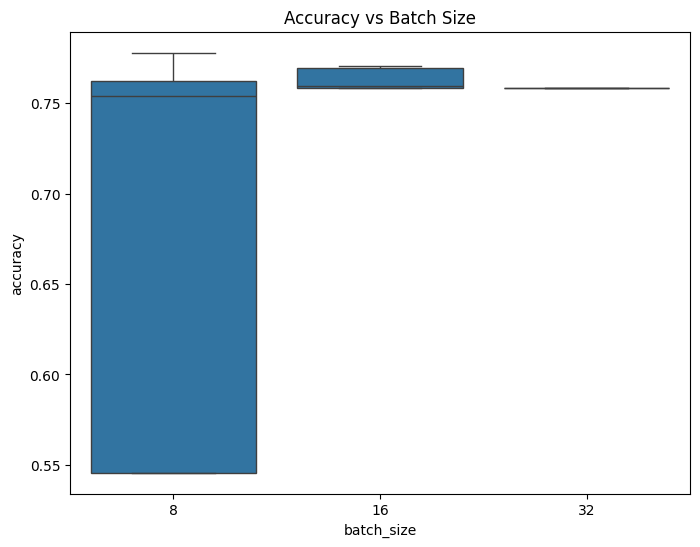

In [ ]:
import json
import pandas as pd
import numpy as np

# === Load non-LoRA experiments ===
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

# Load the experiment logs
non_lora_exps = load_json(NON_LORA_LOG)

# === Convert to DataFrame for easy analysis ===
df_exps = pd.DataFrame(non_lora_exps)

# Show a brief overview of the experiments loaded
print(f"Loaded {len(non_lora_exps)} non-LoRA experiments.")
print("Sample of the experiment records:")
print(df_exps.head())

# === Basic Summary ===
# 1) Average accuracy of all experiments
avg_accuracy = df_exps['accuracy'].mean()
print(f"Average accuracy across all experiments: {avg_accuracy:.4f}")

# 2) Best and worst experiment (by accuracy)
best_exp = df_exps.loc[df_exps['accuracy'].idxmax()]
worst_exp = df_exps.loc[df_exps['accuracy'].idxmin()]

print("\nBest experiment (highest accuracy):")
print(best_exp)
print("\nWorst experiment (lowest accuracy):")
print(worst_exp)

# === Hyperparameter Analysis ===
# 3) Hyperparameter distributions
hyperparams = ['learning_rate', 'batch_size', 'num_epochs', 'weight_decay']
for param in hyperparams:
    print(f"\n{param} distribution:")
    print(df_exps[param].value_counts())

# 4) Identify hyperparameters of the best-performing experiments
print("\nHyperparameters of the best performing experiment:")
print(best_exp[hyperparams])

# === Performance vs Hyperparameters ===
# 5) Correlation between hyperparameters and accuracy
correlations = df_exps[hyperparams + ['accuracy']].corr()
print("\nCorrelation between hyperparameters and accuracy:")
print(correlations)

# === Time Analysis ===
# 6) Average training time
avg_time = df_exps['elapsed_time_sec'].mean()
print(f"\nAverage training time per experiment: {avg_time/60:.2f} minutes")

# 7) Time vs accuracy
df_exps['elapsed_time_min'] = df_exps['elapsed_time_sec'] / 60
best_time_accuracy_corr = df_exps[['elapsed_time_min', 'accuracy']].corr()
print("\nCorrelation between training time and accuracy:")
print(best_time_accuracy_corr)

# === Visualizations ===
# Plotting can be done using libraries like Matplotlib/Seaborn to visualize hyperparameter distributions and performance metrics.

# For example, to visualize accuracy vs batch_size:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_exps, x='batch_size', y='accuracy')
plt.title("Accuracy vs Batch Size")
plt.show()



In [ ]:
import random
import numpy as np
import json
from transformers import AutoConfig, BertTokenizer, Trainer, TrainingArguments, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from datasets import DatasetDict, Dataset
from pathlib import Path

# Path for loading data
DATA_PATH = 'drive/MyDrive/WithLora/cleaned_data.csv'

# Suggested best hyperparameters based on analysis
SUGGESTED_PARAMS = {
    'learning_rate': 0.00005,    # Best performing learning rate
    'batch_size': 8,             # Smaller batch size (8) was favorable
    'num_epochs': 5,             # 5 epochs seem to give the best results
    'weight_decay': 0.01,        # Lower weight decay for better accuracy
}

# --- HELPERS ---
def tokenize_dataset(raw_ds, tokenizer):
    def fn(ex):
        return tokenizer(ex['news'], padding='max_length', truncation=True, max_length=512)
    tok = raw_ds.map(fn, batched=True)
    tok.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    return tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, preds)}

def load_data():
    # Load and split the data
    df = pd.read_csv(DATA_PATH)
    train_df, temp = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['label'], random_state=42)

    raw_ds = DatasetDict({
        'train':     Dataset.from_pandas(train_df),
        'validation':Dataset.from_pandas(val_df),
        'test':      Dataset.from_pandas(test_df),
    })

    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")
    return raw_ds

def train_with_best_params():
    # Load the data
    raw_ds = load_data()

    # Select the best model (for example, the one with the highest average performance across the experiments)
    model_name = "UBC-NLP/MARBERT"  # or you could dynamically choose based on previous analysis

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Tokenize the dataset
    tok_ds = tokenize_dataset(raw_ds, tokenizer)

    # Load the model and apply the best hyperparameters
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    # Set up the Trainer
    args = TrainingArguments(
        output_dir="./best_model_results",
        learning_rate=SUGGESTED_PARAMS['learning_rate'],
        per_device_train_batch_size=SUGGESTED_PARAMS['batch_size'],
        per_device_eval_batch_size=SUGGESTED_PARAMS['batch_size'],
        num_train_epochs=SUGGESTED_PARAMS['num_epochs'],
        weight_decay=SUGGESTED_PARAMS['weight_decay'],
        logging_dir="./logs-best-model",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tok_ds['train'],
        eval_dataset=tok_ds['validation'],
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    metrics = trainer.evaluate(tok_ds['test'])

    # Print final results
    print(f"Final accuracy on test dataset: {metrics['eval_accuracy']}")
    return metrics['eval_accuracy']

# Run the training with the best suggested hyperparameters
final_accuracy = train_with_best_params()
print(f"Best possible accuracy with the suggested hyperparameters: {final_accuracy}")


Train/Val/Test sizes: 7708/964/964


Map:   0%|          | 0/7708 [00:00<?, ? examples/s]

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.694800
1000,0.693700
1500,0.691900
2000,0.692700
2500,0.692400
3000,0.690500
3500,0.690100
4000,0.692700
4500,0.690700


Final accuracy on test dataset: 0.5456431535269709
Best possible accuracy with the suggested hyperparameters: 0.5456431535269709
